In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from itertools import combinations 

from PointTracking_v2 import PointTracker as pt
from classicalfield_orig import FiniteTempGPE as gpe

Let's run the animation with the ideal parameters found to yield stability in the simulation

Total Imag Time:  1.3094019889831543
kmax:  4.0212385965949355
T:  4.042589962686201
(801, 128, 128)
(1, 128, 128)


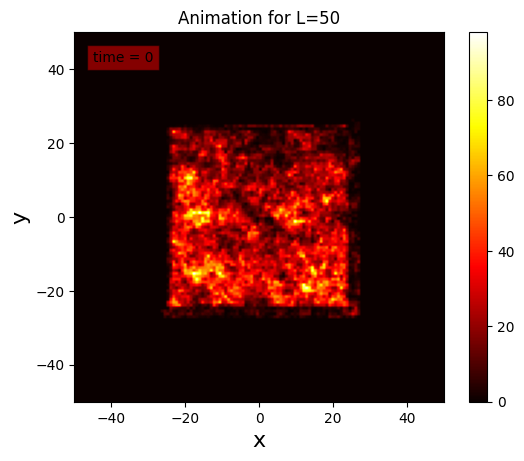

In [2]:
g = gpe(npoints = 2**6, numImagSteps = 2000, numRealSteps = 200000, dtcoef = 0.0005, boxthickness = 0.4, Nsamples = 1, runAnim = True, animFileName = 'test.mp4', Tfact = 1/2, dst = False, vortex = True)

In [3]:
print(g.T)

4.042589962686201


### Make a phase plot 

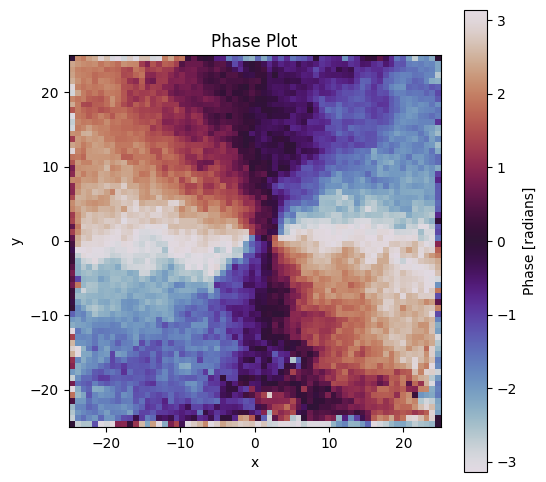

In [4]:
phase = np.angle(g.snaps[0][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx): int(3*g.L/2/g.dx)])

plt.figure(figsize=(6, 6))

plt.imshow(phase, extent=[-g.L/2, g.L/2, -g.L/2, g.L/2], origin='lower', cmap='twilight')
plt.colorbar(label='Phase [radians]')
plt.title('Phase Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
tracker = pt(g.snaps, g.dx, g.L, g.gpeobj.dt)

### Circulation

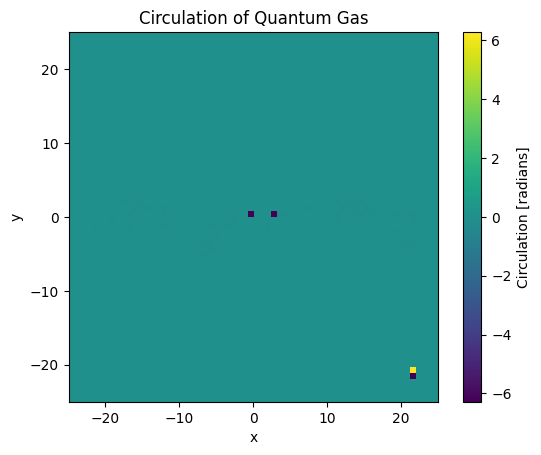

In [6]:
plt.figure() 
plt.imshow(tracker.circulation, extent=[-g.L/2, g.L/2, -g.L/2, g.L/2], origin='lower')
plt.colorbar(label = 'Circulation [radians]') 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circulation of Quantum Gas')
plt.show() 

### Tracking Algorithm

Now, let's implement the tracking for the vortices. The goal is to track the pair of vortices, allowing for the appearance of new vortices, but not tracking them. We can do this by finding the minimum distance between the current vortices and the vortices detected in the next frame.

Edge cases: 
1. What happens when there are extra vortices from the beginning of the simulation? How can you tell which ones are the original vortices? 
    - One solution: see where the vortices begin to disappear and remove them from tracking. This requires a remove function... 
2. What happens when a vortex-anti-vortex pair merges or anhilates? 
    - Also must remove vortices... 
3. Note that we also should not be tracking vortices of the type that were NOT spawned in the first place! filter out this ones via an if statement somewhere

In [7]:
v_traj, antiv_traj, circ_array = pt.labelVortices(tracker, getCirc = True) 

0
1
2


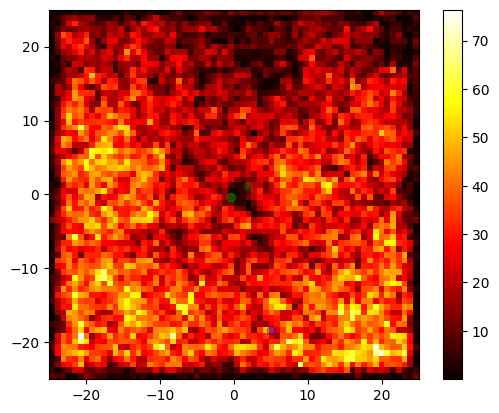

In [8]:
# create a frame-by-frame plot for this
v_traj_arr = np.array(v_traj) 
antiv_traj_arr = np.array(antiv_traj) 

snap_index = 30
plt.figure() 
plt.imshow(np.abs(g.snaps[snap_index][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx): int(3*g.L/2/g.dx)])**2, extent=[-g.L/2, g.L/2, -g.L/2, g.L/2], cmap = plt.cm.hot) # density disrtibution
plt.colorbar()
for i in range(len(v_traj_arr)): 
    plt.scatter(*v_traj_arr[:,snap_index][i]-g.L/2, color = 'blue', alpha = 0.3)
for i in range(len(antiv_traj_arr)): 
    print(i)
    plt.scatter(*antiv_traj_arr[:,snap_index][i]-g.L/2, color = 'green', alpha = 0.3) 



0
1
2


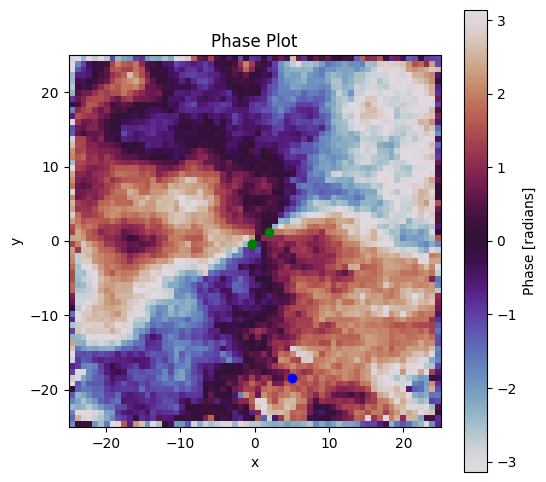

In [9]:
phase = np.angle(g.snaps[snap_index][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx): int(3*g.L/2/g.dx)])

plt.figure(figsize=(6, 6))
plt.imshow(phase, extent=[-g.L/2, g.L/2, -g.L/2, g.L/2], origin='lower', cmap='twilight')
plt.colorbar(label='Phase [radians]')
for i in range(len(v_traj_arr)): 
    plt.scatter(*v_traj_arr[:,snap_index][i]-g.L/2, color = 'blue')
for i in range(len(antiv_traj_arr)): 
    print(i)
    plt.scatter(*antiv_traj_arr[:,snap_index][i]-g.L/2, color = 'green') 
plt.title('Phase Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

0
1
2


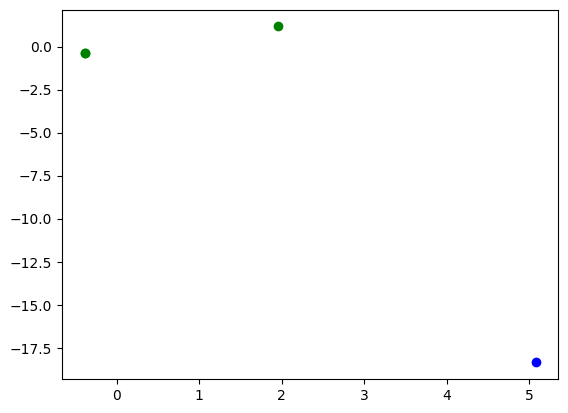

In [10]:
for i in range(len(v_traj_arr)): 
    plt.scatter(*v_traj_arr[:,snap_index][i]-g.L/2, color = 'blue')
for i in range(len(antiv_traj_arr)): 
    print(i)
    plt.scatter(*antiv_traj_arr[:,snap_index][i]-g.L/2, color = 'green') 

    # TODO: why is there an inconsistency between the phase and the circulation plots? 

In [11]:
print(np.shape(circ_array))

(800, 64, 64)


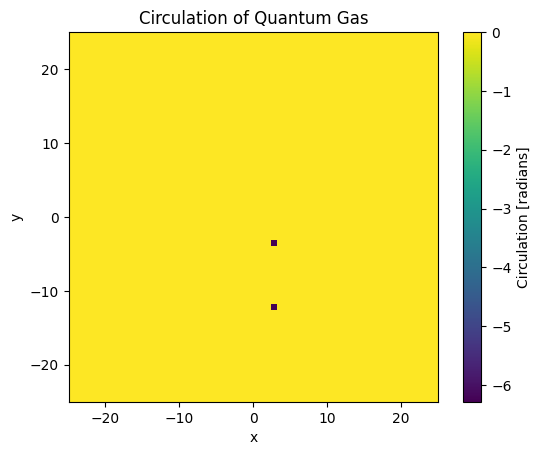

In [12]:
circulation = circ_array[-1]
plt.figure() 
plt.imshow(circulation, extent=[-g.L/2, g.L/2, -g.L/2, g.L/2], origin='lower')
plt.colorbar(label = 'Circulation [radians]') 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Circulation of Quantum Gas')
plt.show() 

### Trajectory Plots

Now, I will plot the distance and angle between the vortices to track their motion

In [13]:
# distance 
vortex_combos = np.array(list(combinations(antiv_traj_arr, 2)))

distance_arr = np.zeros((len(vortex_combos), len(g.snaps)))
angle_arr = np.zeros((len(vortex_combos), len(g.snaps))) 
# initialize distance array to store the distance trajectories for each combination 
## NOTE: maybe make objects in the point array that encode the distance away from a given point or even a DistanceTracker object 

print(np.shape(vortex_combos))
for i, pair in enumerate(vortex_combos): # for each pair - find the distance 
    for j in range(len(vortex_combos[0][0])): 
    #for j in range(280,290):
 
        
        point1 = pair[0][j] 
        point2 = pair[1][j] 
        xsep = point1[0] - point2[0] 
        ysep = point1[1] - point2[1] 
        dist = np.sqrt(np.abs(point1[0] - point2[0])**2 + np.abs(point1[1] - point2[1])**2) 
        ang = np.arctan(ysep/xsep) 
        print(ang) 
        print("")
        distance_arr[i,j] = dist 
        angle_arr[i,j] = ang


(3, 2, 801, 2)
-0.7853981633974483

-0.7853981633974483

-0.7678561033400458

-0.7853981633974483

-0.7853981633974483

-0.76721834832447

-0.76721834832447

-0.76721834832447

-0.7853981633974483

-0.7853981633974483

-0.7483780475235183

-0.7483780475235183

-0.7483780475235183

-0.7483780475235183

-0.7483780475235183

-1.1479424006619559

-1.1479424006619559

-1.1284221038181517

-1.1284221038181517

-1.0679531158670357

-0.7469555733762603

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan

nan



C:\Users\TQC User\AppData\Local\Temp\ipykernel_27096\421453469.py:20: RuntimeWarning: invalid value encountered in scalar divide
  ang = np.arctan(ysep/xsep)
C:\Users\TQC User\AppData\Local\Temp\ipykernel_27096\421453469.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  ang = np.arctan(ysep/xsep)


In [14]:
print(np.shape(distance_arr))

(3, 801)


Text(0.5, 1.0, 'Distance between vortices')

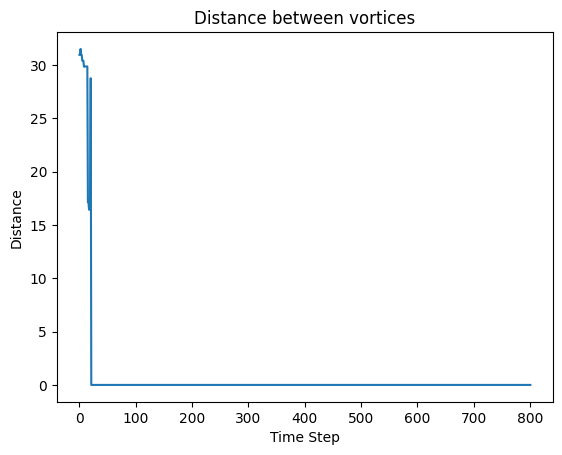

In [15]:
plt.figure() 
plt.plot(np.linspace(0,len(distance_arr[0]), len(distance_arr[0])), distance_arr[0])
plt.xlabel('Time Step')
plt.ylabel('Distance') 
plt.title('Distance between vortices')
#plt.xlim(0,1000)


Text(0.5, 1.0, 'Angle between vortices')

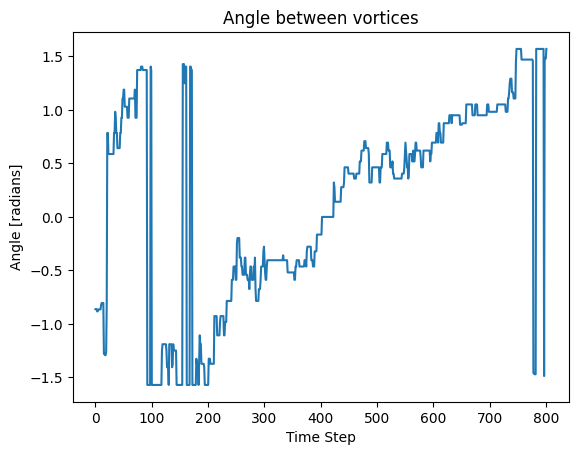

In [16]:
plt.figure() 
plt.plot(np.linspace(0,len(distance_arr[0]), len(distance_arr[0])), angle_arr[1])


plt.xlabel('Time Step')
plt.ylabel('Angle [radians]') 
plt.title('Angle between vortices')

### Animating the Plot

TODO: Figure out this animation plot with the trackers to see if it does as we expect 

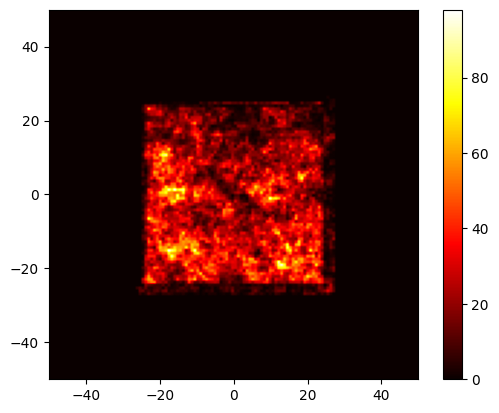

In [17]:
plt.figure() 
plt.imshow(np.abs(g.snaps[0])**2, extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2],cmap = plt.cm.hot)
plt.colorbar() 

In [18]:
%matplotlib widget
def animatepsi(filename): 
    time_tracking = np.arange(0, len(g.snaps))*250*g.gpeobj.dt
    if filename != None: 
            path = fr"C:\Users\TQC User\Desktop\BECs2\{filename}.mp4"
    fig, ax = plt.subplots() 
    data = plt.imshow(np.abs(g.snaps[0])**2, extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2], cmap = plt.cm.hot, origin = 'lower')
    plt.colorbar() 
    L = g.L 
    vort_arr = [] 

    # initialize vortex locations 
    for i in range(len(antiv_traj_arr)): 
        avi_traj = antiv_traj_arr[i] # the trajecory of the ith antivortex 
        vi = plt.scatter(avi_traj[0][0]+0.5-L/2, avi_traj[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')
        vort_arr.append(vi)


    time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='red', alpha=0.5))
    time_text.set_text('time = 0')

    plt.xlabel("x", fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    plt.title(f'Animation for L={L}')


# animation part 
    def animate(i): 
        data.set_data(np.abs(g.snaps[i])**2)
        # loop over the existing points 
        for j in range(len(vort_arr)): 
            vort_arr[j].set_offsets([avi_traj[j][0]+0.5-L/2,avi_traj[j][1]+0.5-L/2])
 
        time_text.set_text('time = %.1d' % time_tracking[i]) # find an array that tracks the time or define one based on dt and the number of points 
        #return data, time_text
        return data, time_text, *vort_arr
    anim = animation.FuncAnimation(fig, animate, frames = len(g.snaps), blit = True)
    anim.save(path)
    plt.show()

    return anim 

# plt.xlim(-10,10)
# plt.ylim(-10,10)

In [19]:
# try with just two vortices 

def animatepsi2(filename): 
    time_tracking = np.arange(0, len(g.snaps))*250*g.gpeobj.dt
    if filename != None: 
            path = fr"C:\Users\TQC User\Desktop\BECs2\{filename}.mp4"
    fig, ax = plt.subplots() 
    data = plt.imshow(np.abs(g.snaps[0])**2, extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2], cmap = plt.cm.hot, origin = 'lower')
    plt.colorbar() 
    L = g.L

    # avi_traj1 = antiv_traj_arr[0] # the trajecory of the ith antivortex 
    # v1 = plt.scatter(avi_traj1[0][0]+0.5-L/2, avi_traj1[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')

    # avi_traj2 = antiv_traj_arr[1] # the trajecory of the ith antivortex 
    # v2 = plt.scatter(avi_traj2[0][0]+0.5-L/2, avi_traj2[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')


    # try storing in an array 
    vort_arr = [] 
    
    for i in range(len(antiv_traj_arr)): 
         avi_traj = antiv_traj_arr[i] 
         v = plt.scatter(avi_traj[0][0]+0.5-L/2, avi_traj[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')
         vort_arr.append(v) 
    ### 
    # v1 = vort_arr[0]
    # v2 = vort_arr[1]


    time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='red', alpha=0.5))
    time_text.set_text('time = 0')

    plt.xlabel("x", fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    plt.title(f'Animation for L={L}')

    def animate(i): 
        data.set_data(np.abs(g.snaps[i])**2)
        # loop over the existing points 
        #print(vort_arr[0])
        #v1.set_offsets([antiv_traj_arr[0][i][0]+0.5-L/2, antiv_traj_arr[0][i][1]+0.5-L/2])
        #v2.set_offsets([antiv_traj_arr[1][i][0]+0.5-L/2, antiv_traj_arr[1][i][1]+0.5-L/2])

        for j in range(len(vort_arr)): 
             vort_arr[j].set_offsets([antiv_traj_arr[j][i][0]+0.5-L/2, antiv_traj_arr[j][i][1]+0.5-L/2])
 
        time_text.set_text('time = %.1d' % time_tracking[i]) # find an array that tracks the time or define one based on dt and the number of points 
        #return data, time_text

        #vort_arr = [v1,v2]
        return data, time_text, *vort_arr
    anim = animation.FuncAnimation(fig, animate, frames = len(g.snaps), blit = True)
    anim.save(path)
    plt.show() 

    return anim 
    

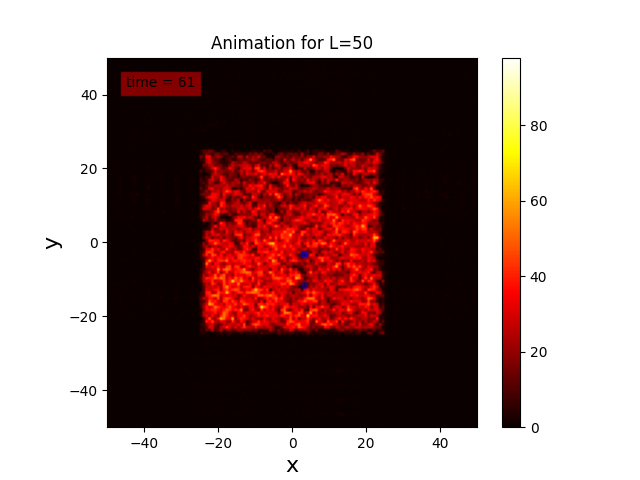

In [20]:
animatepsi2('test3.mp4')

Investigate into why the vortex disappeared

### Animating the Circulation

It could also be interesting to animate the circulation and phase of the vortices to see if there are things that are being missed or unseen by the main tracking animation. 

In [63]:
# try with just two vortices 

def generalAnimation(filename, dataset, periodic = False): 
    time_tracking = np.arange(0, len(dataset))*250*g.gpeobj.dt
    if filename != None: 
            path = fr"C:\Users\TQC User\Desktop\BECs2\{filename}.mp4"
    fig, ax = plt.subplots() 
    if not periodic: 
        data = plt.imshow(dataset[0],  extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2], origin = 'lower')
    else: 
        data = plt.imshow(dataset[0], extent = [-g.winL/2, g.winL/2, -g.winL/2, g.winL/2], cmap = 'twilight', origin = 'lower')
    plt.colorbar() 
    plt.clim(-2*np.pi, 2*np.pi)

     
    L = g.L

    # avi_traj1 = antiv_traj_arr[0] # the trajecory of the ith antivortex 
    # v1 = plt.scatter(avi_traj1[0][0]+0.5-L/2, avi_traj1[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')

    # avi_traj2 = antiv_traj_arr[1] # the trajecory of the ith antivortex 
    # v2 = plt.scatter(avi_traj2[0][0]+0.5-L/2, avi_traj2[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')


    # try storing in an array 
#     vort_arr = [] 
    
#     for i in range(len(antiv_traj_arr)): 
#          avi_traj = antiv_traj_arr[i] 
#          v = plt.scatter(avi_traj[0][0]+0.5-L/2, avi_traj[0][1]+0.5-L/2, alpha = 0.3, s = 20, color = 'blue')
#          vort_arr.append(v) 
    ### 
    # v1 = vort_arr[0]
    # v2 = vort_arr[1]


    time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='red', alpha=0.5))
    time_text.set_text('time = 0')

    plt.xlabel("x", fontsize = 16)
    plt.ylabel('y', fontsize = 16)
    plt.title(f'Animation for L={L}')

    def animate(i): 
        data.set_data(dataset[i])


     #    for j in range(len(vort_arr)): 
     #         vort_arr[j].set_offsets([antiv_traj_arr[j][i][0]+0.5-L/2, antiv_traj_arr[j][i][1]+0.5-L/2])
 
        time_text.set_text('time = %.1d' % time_tracking[i]) # find an array that tracks the time or define one based on dt and the number of points 
        #return data, time_text

        #vort_arr = [v1,v2]
        return data, time_text
    anim = animation.FuncAnimation(fig, animate, frames = len(dataset), blit = True)
    anim.save(path)
    
    plt.show() 

    return anim 
    

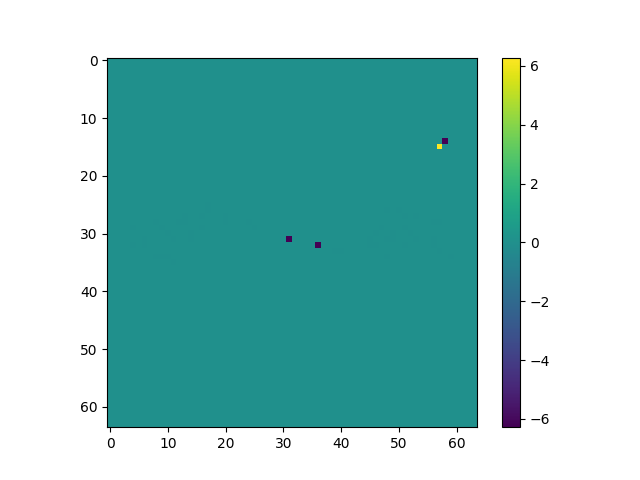

In [62]:
plt.figure()
plt.imshow(circ_array[1])
plt.colorbar() 
plt.show() 

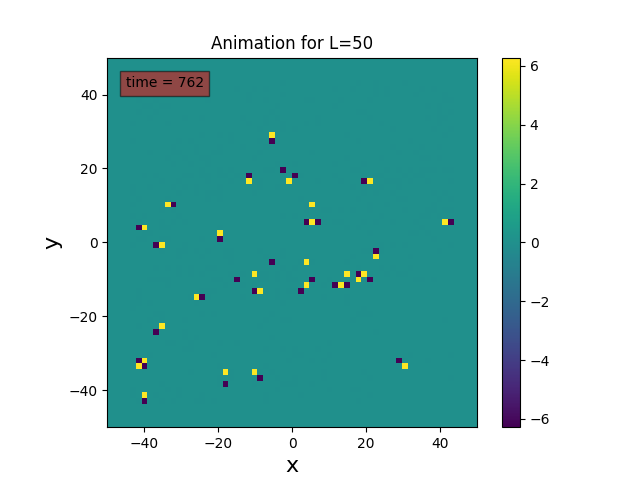

In [64]:
generalAnimation('circ5.mp4', circ_array)

In [45]:
# Animating the Phase 
phase = [] 
for snap in range(len(g.snaps)): 
    phase.append(np.angle(g.snaps[snap][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx): int(3*g.L/2/g.dx)]))
phase_arr = np.array(phase)

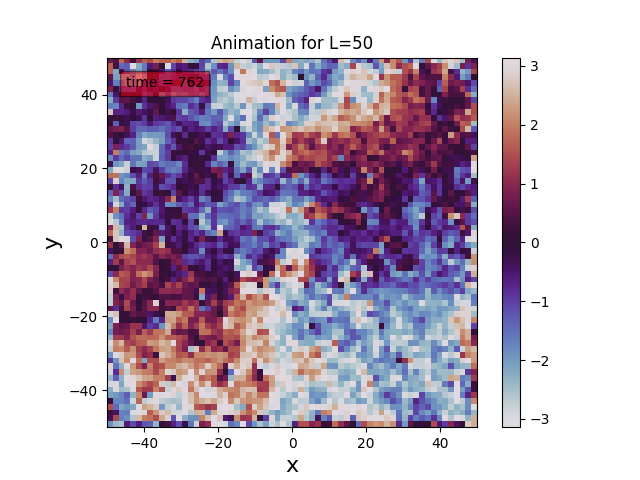

In [46]:
generalAnimation('phase3.mp4', phase_arr, periodic = True)

TODO: Test the different cases now that the animation is working 
- Is the animation handling vortices disappearing ok? if not, implement a removal algorithm
    - It seems that the animation is in general handling the elimination of vortices ok, but it handles it in the way that it treats a given vortex as multiple vortices. I anticipate that this is ok for the trajectories, but it doesn't really make sense and I should really figure out how to handle an elimination of a vortex.
- How do the trajectories look? 
- Test for higher temperatures 
- Read up on mutual friction coefficients 

### MISC Notes

To be done - fix the pre-existing tracker to track only the main vortices and ignore the other ones 

Do this by doing the same euclidean distance thing in the newer algorithm and ignore all points that are not used. This should theoretically work... 

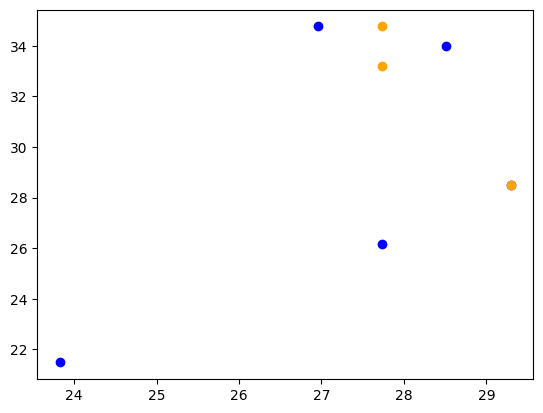

In [7]:
from scipy.cluster.vq import vq

features  = np.array([(29.296875, 28.515625), (27.734375, 33.203125), (27.734375, 34.765625)])

code_book = np.array([[23.828125, 21.484375],[27.734375, 26.171875],[29.296875, 28.515625],[28.515625, 33.984375],[26.953125, 34.765625]])

plt.figure() 
for i in range(len(code_book)): 
    plt.scatter(code_book[i][0], code_book[i][1], color = 'blue')
for i in range(len(features)): 
    plt.scatter(features[i][0], features[i][1], color = 'orange')
plt.show() 


In [6]:
vq( features, code_book)

(array([2, 3, 4]), array([0.        , 1.10485435, 0.78125   ]))

In [ ]:
from collections import defaultdict
source = "ABABDBAAEDSBQEWBAFLSAFB"
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() if len(locs)>1)

for dup in sorted(list_duplicates(source)):
    print(dup)